# Классификация областей полученных от детектора прямоугольников

## 1. Подготовка датасета

Датасет состоит из примерно 600 изображений в каждой категории: шахматные доски, доски для го, другие прямоугольные изображения

+ Шахматный датасет взят из проекта [https://github.com/gudbrandtandberg/ChessVision]().
+ Датасет досок го [https://github.com/skolchin/gbr]() \(разпознавание го методами opencv\)
+ Датасет иллюстраций из книг получен с помощью написанного скрипта `pdf_pages_extractor` и архива книг по машинному обучению

In [3]:
import os
import cv2
import json

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torchvision.transforms as tt
import torch.nn as nn
import torch.optim as optim

from PIL import Image

from IPython.display import clear_output
from tqdm.notebook import tqdm

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set(style='darkgrid', font_scale=1.2)

In [4]:
def best_torch_device():
    try:
        import torch_xla
        import torch_xla.core.xla_model as xm
        from torch_xla.distributed.parallel_loader import ParallelLoader

        print("TPU is available")
        return xm.xla_device()
        
    except ImportError:
        print("TPU not available, using GPU/CPU instead")

        if torch.cuda.is_available():
            print('GPU is available')
            !nvidia-smi
            return torch.device('cuda')            
        elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
            return torch.device('mps')
        else:
            return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

def empty_torch_cache():
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
        torch.mps.empty_cache()

    # torch.cuda.ipc_collect()
    

DEVICE = best_torch_device()
print(f"Using device: {DEVICE}")

TPU not available, using GPU/CPU instead
Using device: mps


In [5]:
import random

DEFAULT_RANDOM_SEED = 1984
      
def seed_everything(seed: int):
    def seed_basic(seed: int):
        random.seed(seed)
        os.environ['PYTHONHASHSEED'] = str(seed)
        np.random.seed(seed)
        
    def seed_torch(seed: int):
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(seed)
            torch.cuda.manual_seed_all(seed)
        if torch.backends.mps.is_available():
            torch.mps.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    seed_basic(seed)
    seed_torch(seed)

seed_everything(DEFAULT_RANDOM_SEED)

In [6]:
from torchvision.io import read_image
from torchvision.utils import save_image
from torchvision.datasets import DatasetFolder
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader

class ChessGoDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        self.label_names = {'chess': 0, 'go': 1, 'other': 2}
        
        for label_name, label in self.label_names.items():
            folder_path = os.path.join(root_dir, label_name)
            for img_name in os.listdir(folder_path):
                self.images.append(os.path.join(folder_path, img_name))
                self.labels.append(label)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path)
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)

        image = torch.tensor(np.array(image), dtype=torch.float32)
        return image, label

In [7]:
from PIL import Image, ImageOps
import math

class ResizeAndPad(object):
    def __init__(self, output_size, fill=255):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size
        self.fill = fill

    def __call__(self, img):
        img = ImageOps.pad(img, self.output_size, method=Image.Resampling.LANCZOS, color=self.fill)
        return img

def input_transforms():
    return tt.Compose([
        tt.Lambda(lambda img: img.convert('RGB')),
        ResizeAndPad(224, fill=(255, 255, 255)),
        tt.ToTensor(),
    ])

In [8]:
from torch.utils.data.sampler import SubsetRandomSampler

def create_split_loaders(dataset, batch_size=32, validation_split=0.2, shuffle_dataset=True, random_seed=DEFAULT_RANDOM_SEED):
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    split = int(np.floor(validation_split * dataset_size))

    if shuffle_dataset:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_indices, val_indices = indices[split:], indices[:split]

    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)

    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    validation_loader = DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler)

    return train_loader, validation_loader


In [9]:
dataset_path = '../classification_dataset'
dataset = ChessGoDataset(root_dir=dataset_path, transform=input_transforms())
train_loader, validation_loader = create_split_loaders(dataset, batch_size=8, validation_split=0.2)

In [10]:
from torchvision.transforms.functional import to_pil_image

def show_images_with_boxes(dataloader, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 5, 5))

    for i, (images, _) in enumerate(dataloader):
        if i >= num_images:
            break

        image_tensor = images[0]
        image = to_pil_image(image_tensor.clamp(min=0, max=1).detach().cpu())

        if num_images == 1:
            axes = [axes]

        ax = axes[i]
        ax.imshow(image)

        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"Image {i+1}")

    plt.tight_layout()
    plt.show()



Примеры изображений

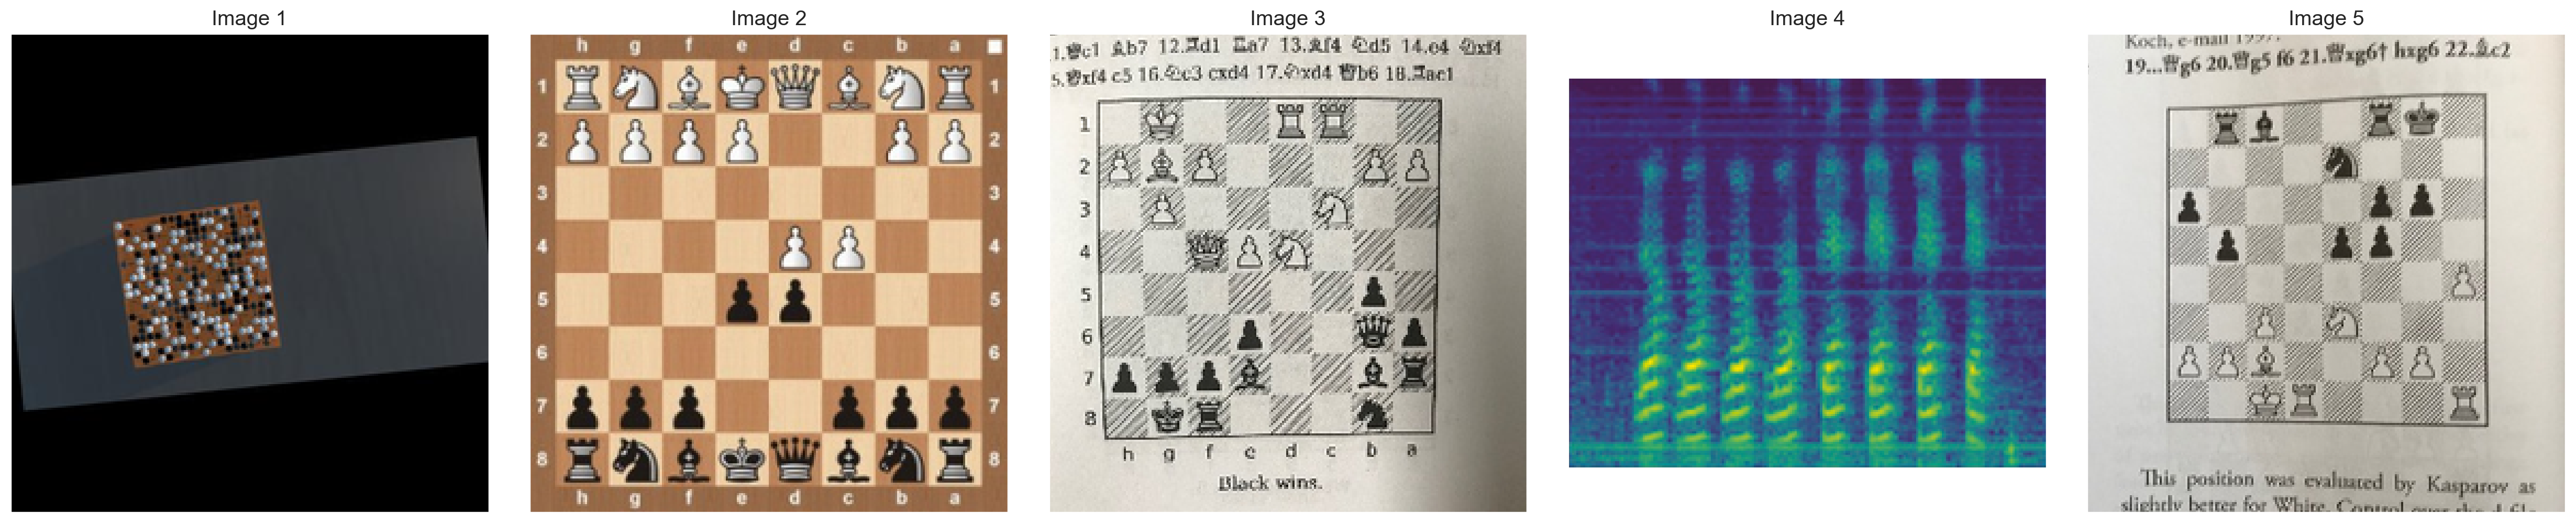

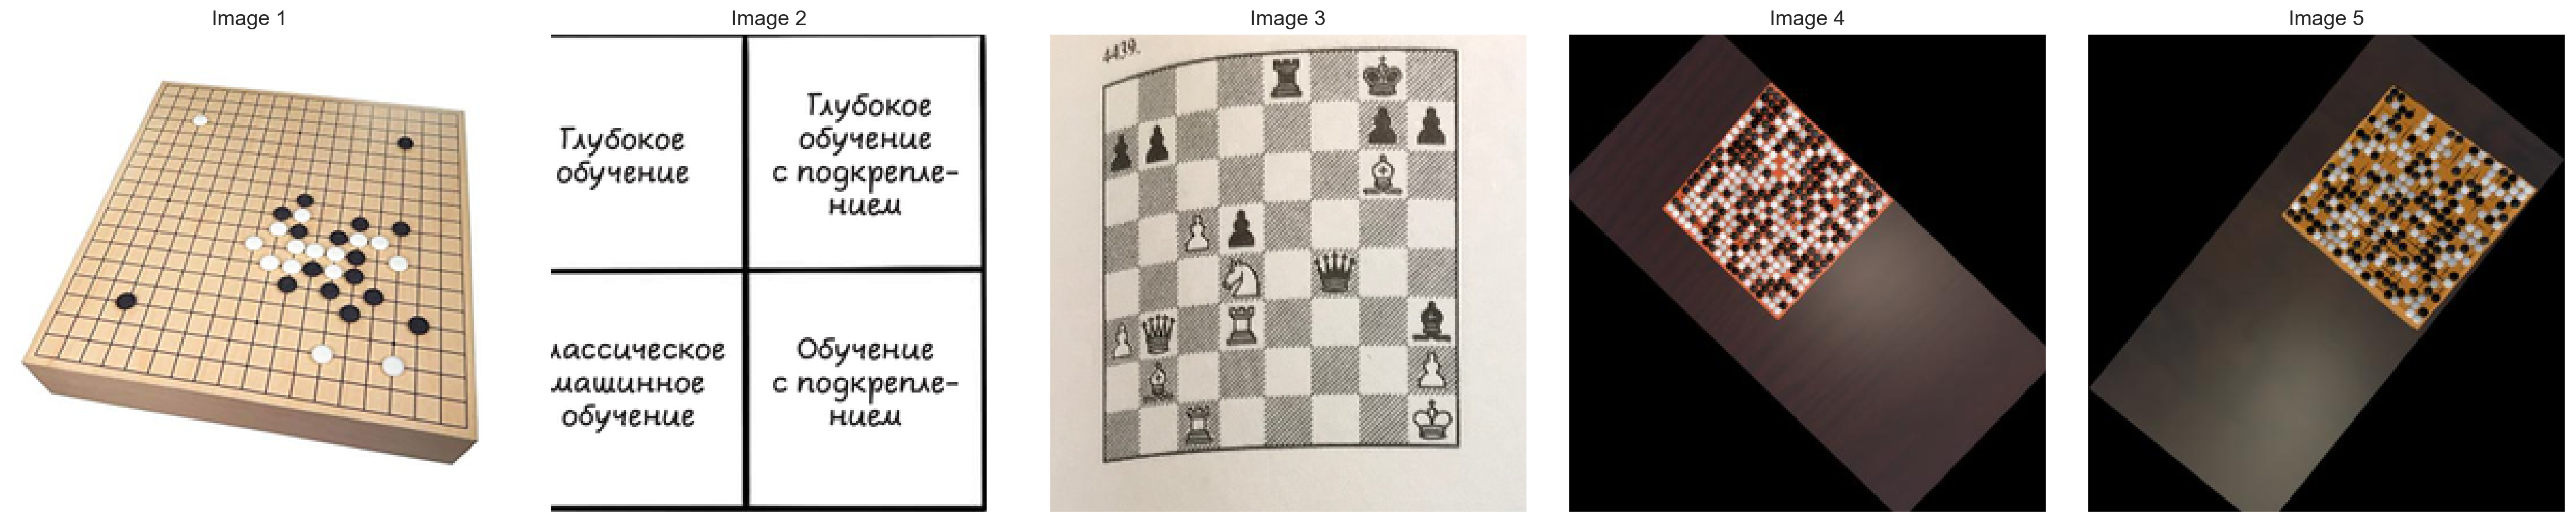

In [11]:
show_images_with_boxes(train_loader)
show_images_with_boxes(validation_loader)

In [12]:
from collections import Counter

print(f'Found {len(dataset)} files in dataset')

for images, labels in train_loader:
    print(f"Batch of images: {images.shape}")
    print(f"Batch of labels: {labels}")
    break

print(f"Label distribution: {Counter(dataset.labels)}")

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(validation_loader)}")

Found 1887 files in dataset
Batch of images: torch.Size([8, 3, 224, 224])
Batch of labels: tensor([0, 0, 1, 2, 2, 0, 2, 1])
Label distribution: Counter({1: 649, 0: 631, 2: 607})
Number of training batches: 189
Number of validation batches: 48


## 2. Обучение классификатора на основе Squeezenet

In [13]:
import torch.nn as nn
import torchvision.models as models

squeezenet = models.squeezenet1_1(pretrained=True)
num_classes = len(dataset.label_names)

squeezenet.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
squeezenet.num_classes = num_classes

/Users/nazaroff/.pyenv/versions/3.11.3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/nazaroff/.pyenv/versions/3.11.3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
from torchinfo import summary
summary(squeezenet)

Layer (type:depth-idx)                   Param #
SqueezeNet                               --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       1,792
│    └─ReLU: 2-2                         --
│    └─MaxPool2d: 2-3                    --
│    └─Fire: 2-4                         --
│    │    └─Conv2d: 3-1                  1,040
│    │    └─ReLU: 3-2                    --
│    │    └─Conv2d: 3-3                  1,088
│    │    └─ReLU: 3-4                    --
│    │    └─Conv2d: 3-5                  9,280
│    │    └─ReLU: 3-6                    --
│    └─Fire: 2-5                         --
│    │    └─Conv2d: 3-7                  2,064
│    │    └─ReLU: 3-8                    --
│    │    └─Conv2d: 3-9                  1,088
│    │    └─ReLU: 3-10                   --
│    │    └─Conv2d: 3-11                 9,280
│    │    └─ReLU: 3-12                   --
│    └─MaxPool2d: 2-6                    --
│    └─Fire: 2-7                         --
│    │

In [13]:
from torchsummary import summary
summary(squeezenet, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 111, 111]           1,792
              ReLU-2         [-1, 64, 111, 111]               0
         MaxPool2d-3           [-1, 64, 55, 55]               0
            Conv2d-4           [-1, 16, 55, 55]           1,040
              ReLU-5           [-1, 16, 55, 55]               0
            Conv2d-6           [-1, 64, 55, 55]           1,088
              ReLU-7           [-1, 64, 55, 55]               0
            Conv2d-8           [-1, 64, 55, 55]           9,280
              ReLU-9           [-1, 64, 55, 55]               0
             Fire-10          [-1, 128, 55, 55]               0
           Conv2d-11           [-1, 16, 55, 55]           2,064
             ReLU-12           [-1, 16, 55, 55]               0
           Conv2d-13           [-1, 64, 55, 55]           1,088
             ReLU-14           [-1, 64,

In [14]:
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim
import torch.nn as nn

def train(model, name, train_loader, validation_loader, device=DEVICE):
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    writer = SummaryWriter()

    num_epochs = 30 
    save_interval = 5

    train_losses = []
    val_accuracies = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

            if i % 100 == 99:
                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {running_loss/100:.4f}")
                writer.add_scalar('Training Loss', running_loss/100, epoch * len(train_loader) + i)
                running_loss = 0.0

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in validation_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            accuracy = 100 * correct / total
            val_accuracies.append(accuracy)
            print(f"Epoch [{epoch+1}/{num_epochs}], Validation Accuracy: {accuracy:.2f}%")
            writer.add_scalar('Validation Accuracy', accuracy, epoch)

        if epoch % save_interval == 0:
            torch.save(model.state_dict(), f"{name}_epoch_{epoch+1}.pth")

    writer.close()

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [ ]:
train(squeezenet, name="squeezenet", train_loader=train_loader, validation_loader=validation_loader)

In [15]:
! pip install coremltools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.1 MB/s eta 0:00:00 0:00:01m


In [31]:
import coremltools as ct
from regex import P

squeezenet = models.squeezenet1_1(pretrained=False)
squeezenet.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
squeezenet.num_classes = num_classes

model_path = 'squeezenet_epoch_26.pth'
squeezenet.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
squeezenet.eval()

example_input = torch.randn((1,3,224,224))
traced_model = torch.jit.trace(squeezenet, example_input)

scale = 1/255.0  # 1/(0.226*255.0)
bias = [0,0,0]   # [- 0.485/(0.229) , - 0.456/(0.224), - 0.406/(0.225)]

def save_model(ct_model, name):
    ct_model.short_description = "Image classifier for detecting chess and go boards"
    ct_model.author = "Alex Nazarov"
    ct_model.license = "Copyright (c) 2024 Alex Nazarov"
    ct_model.version = "1.0"
    ct_model.save(f'{name}.mlpackage')

save_model(ct.convert(
    traced_model,
    inputs=[ct.ImageType(name="image", shape=example_input.shape, scale=scale, bias=bias)],
    outputs=[ct.TensorType(name="class")],
    classifier_config=ct.ClassifierConfig(["chess", "go", "other"], predicted_feature_name='labels', predicted_probabilities_output=None),
    minimum_deployment_target=ct.target.iOS15,
    compute_precision=ct.precision.FLOAT16,
    source="pytorch",
    convert_to='mlprogram'
), name="models/chssnet_sn_strings")

# Модель со строковыми лейблами фейлится при оптимизации, багрепорт до сих пор открыт на гитхабе
save_model(ct.convert(
    traced_model,
    inputs=[ct.ImageType(name="image", shape=example_input.shape, scale=scale, bias=bias)],
    outputs=[ct.TensorType(name="class")],
    minimum_deployment_target=ct.target.iOS15,
    compute_precision=ct.precision.FLOAT16,
    source="pytorch",
    convert_to='mlprogram'
), name="models/chssnet_sn_f16")

/Users/nazaroff/.pyenv/versions/3.11.3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/nazaroff/.pyenv/versions/3.11.3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Running MIL backend_mlprogram pipeline: 100%|██████████| 12/12 [00:00<00:00, 2248.86 passes/s]


In [32]:
import coremltools as ct
import coremltools.optimize.coreml as cto

# Add 8-bit linear quantization
mlmodel = ct.models.MLModel('models/chssnet_sn_f16.mlpackage')
op_config = cto.OpLinearQuantizerConfig(mode="linear_symmetric")
compressed_mlmodel = cto.linear_quantize_weights(mlmodel, cto.OptimizationConfig(global_config=op_config))
compressed_mlmodel.save('models/chssnet_sn_i8.mlpackage')

Running compression pass linear_quantize_weights: 100%|██████████| 51/51 [00:00<00:00, 2394.49 ops/s]
Running MIL frontend_milinternal pipeline: 0 passes [00:00, ? passes/s]
Running MIL backend_mlprogram pipeline: 100%|██████████| 12/12 [00:00<00:00, 1600.62 passes/s]


Протестируем сконвертированные модели и убедимся, что результаты не отличаются

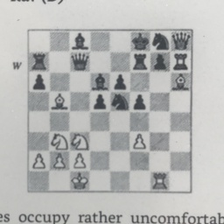

In [17]:
img_chess = Image.open("../classification_dataset/chess/01d4d003-71af-4d1a-a8e7-98c781211928.JPG").resize([224, 224], Image.LANCZOS)
img_chess

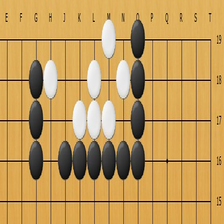

In [18]:
img_go = Image.open("../classification_dataset/go/go_board_104.png").resize([224, 224], Image.LANCZOS)
img_go

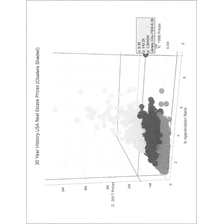

In [19]:
img_other = Image.open("../classification_dataset/other/_rect_263_0.png").resize([224, 224], Image.LANCZOS)
img_other

In [33]:
coreml_model_str = ct.models.MLModel('models/chssnet_sn_strings.mlpackage')
print("chess", coreml_model_str.predict({'image': img_chess})['class'])
print("go", coreml_model_str.predict({'image': img_go})['class'])
print("other", coreml_model_str.predict({'image': img_other})['class'])
print("")

coreml_model_f16 = ct.models.MLModel('models/chssnet_sn_f16.mlpackage')
print("chess", coreml_model_f16.predict({'image': img_chess})['class'])
print("go", coreml_model_f16.predict({'image': img_go})['class'])
print("other", coreml_model_f16.predict({'image': img_other})['class'])
print("")

coreml_model_i8 = ct.models.MLModel('models/chssnet_sn_i8.mlpackage')
print("chess", coreml_model_i8.predict({'image': img_chess})['class'])
print("go", coreml_model_i8.predict({'image': img_go})['class'])
print("other", coreml_model_i8.predict({'image': img_other})['class'])

chess [[11.6328125   0.01207733  4.20703125]]
go [[ 0.43652344 19.875       1.34570312]]
other [[0.67675781 0.12298584 4.9296875 ]]

chess [[11.6328125   0.01207733  4.2070312 ]]
go [[ 0.43652344 19.875       1.3457031 ]]
other [[0.6767578  0.12298584 4.9296875 ]]

chess [[11.640625    0.01177979  4.1601562 ]]
go [[ 0.4411621 19.90625    1.3476562]]
other [[0.6855469  0.12304688 4.8632812 ]]


Похоже что предишены работают правильно. Проверим больше изображений

In [21]:
num_samples = 200
total_samples = len(dataset)
random_indices = np.random.choice(total_samples, num_samples, replace=False)

pytorch_images = [dataset[i][0] for i in random_indices]
coreml_images = [Image.fromarray((dataset[i][0].permute(1, 2, 0).numpy() * 255).astype(np.uint8)) for i in random_indices]
true_labels = [dataset[i][1] for i in random_indices]

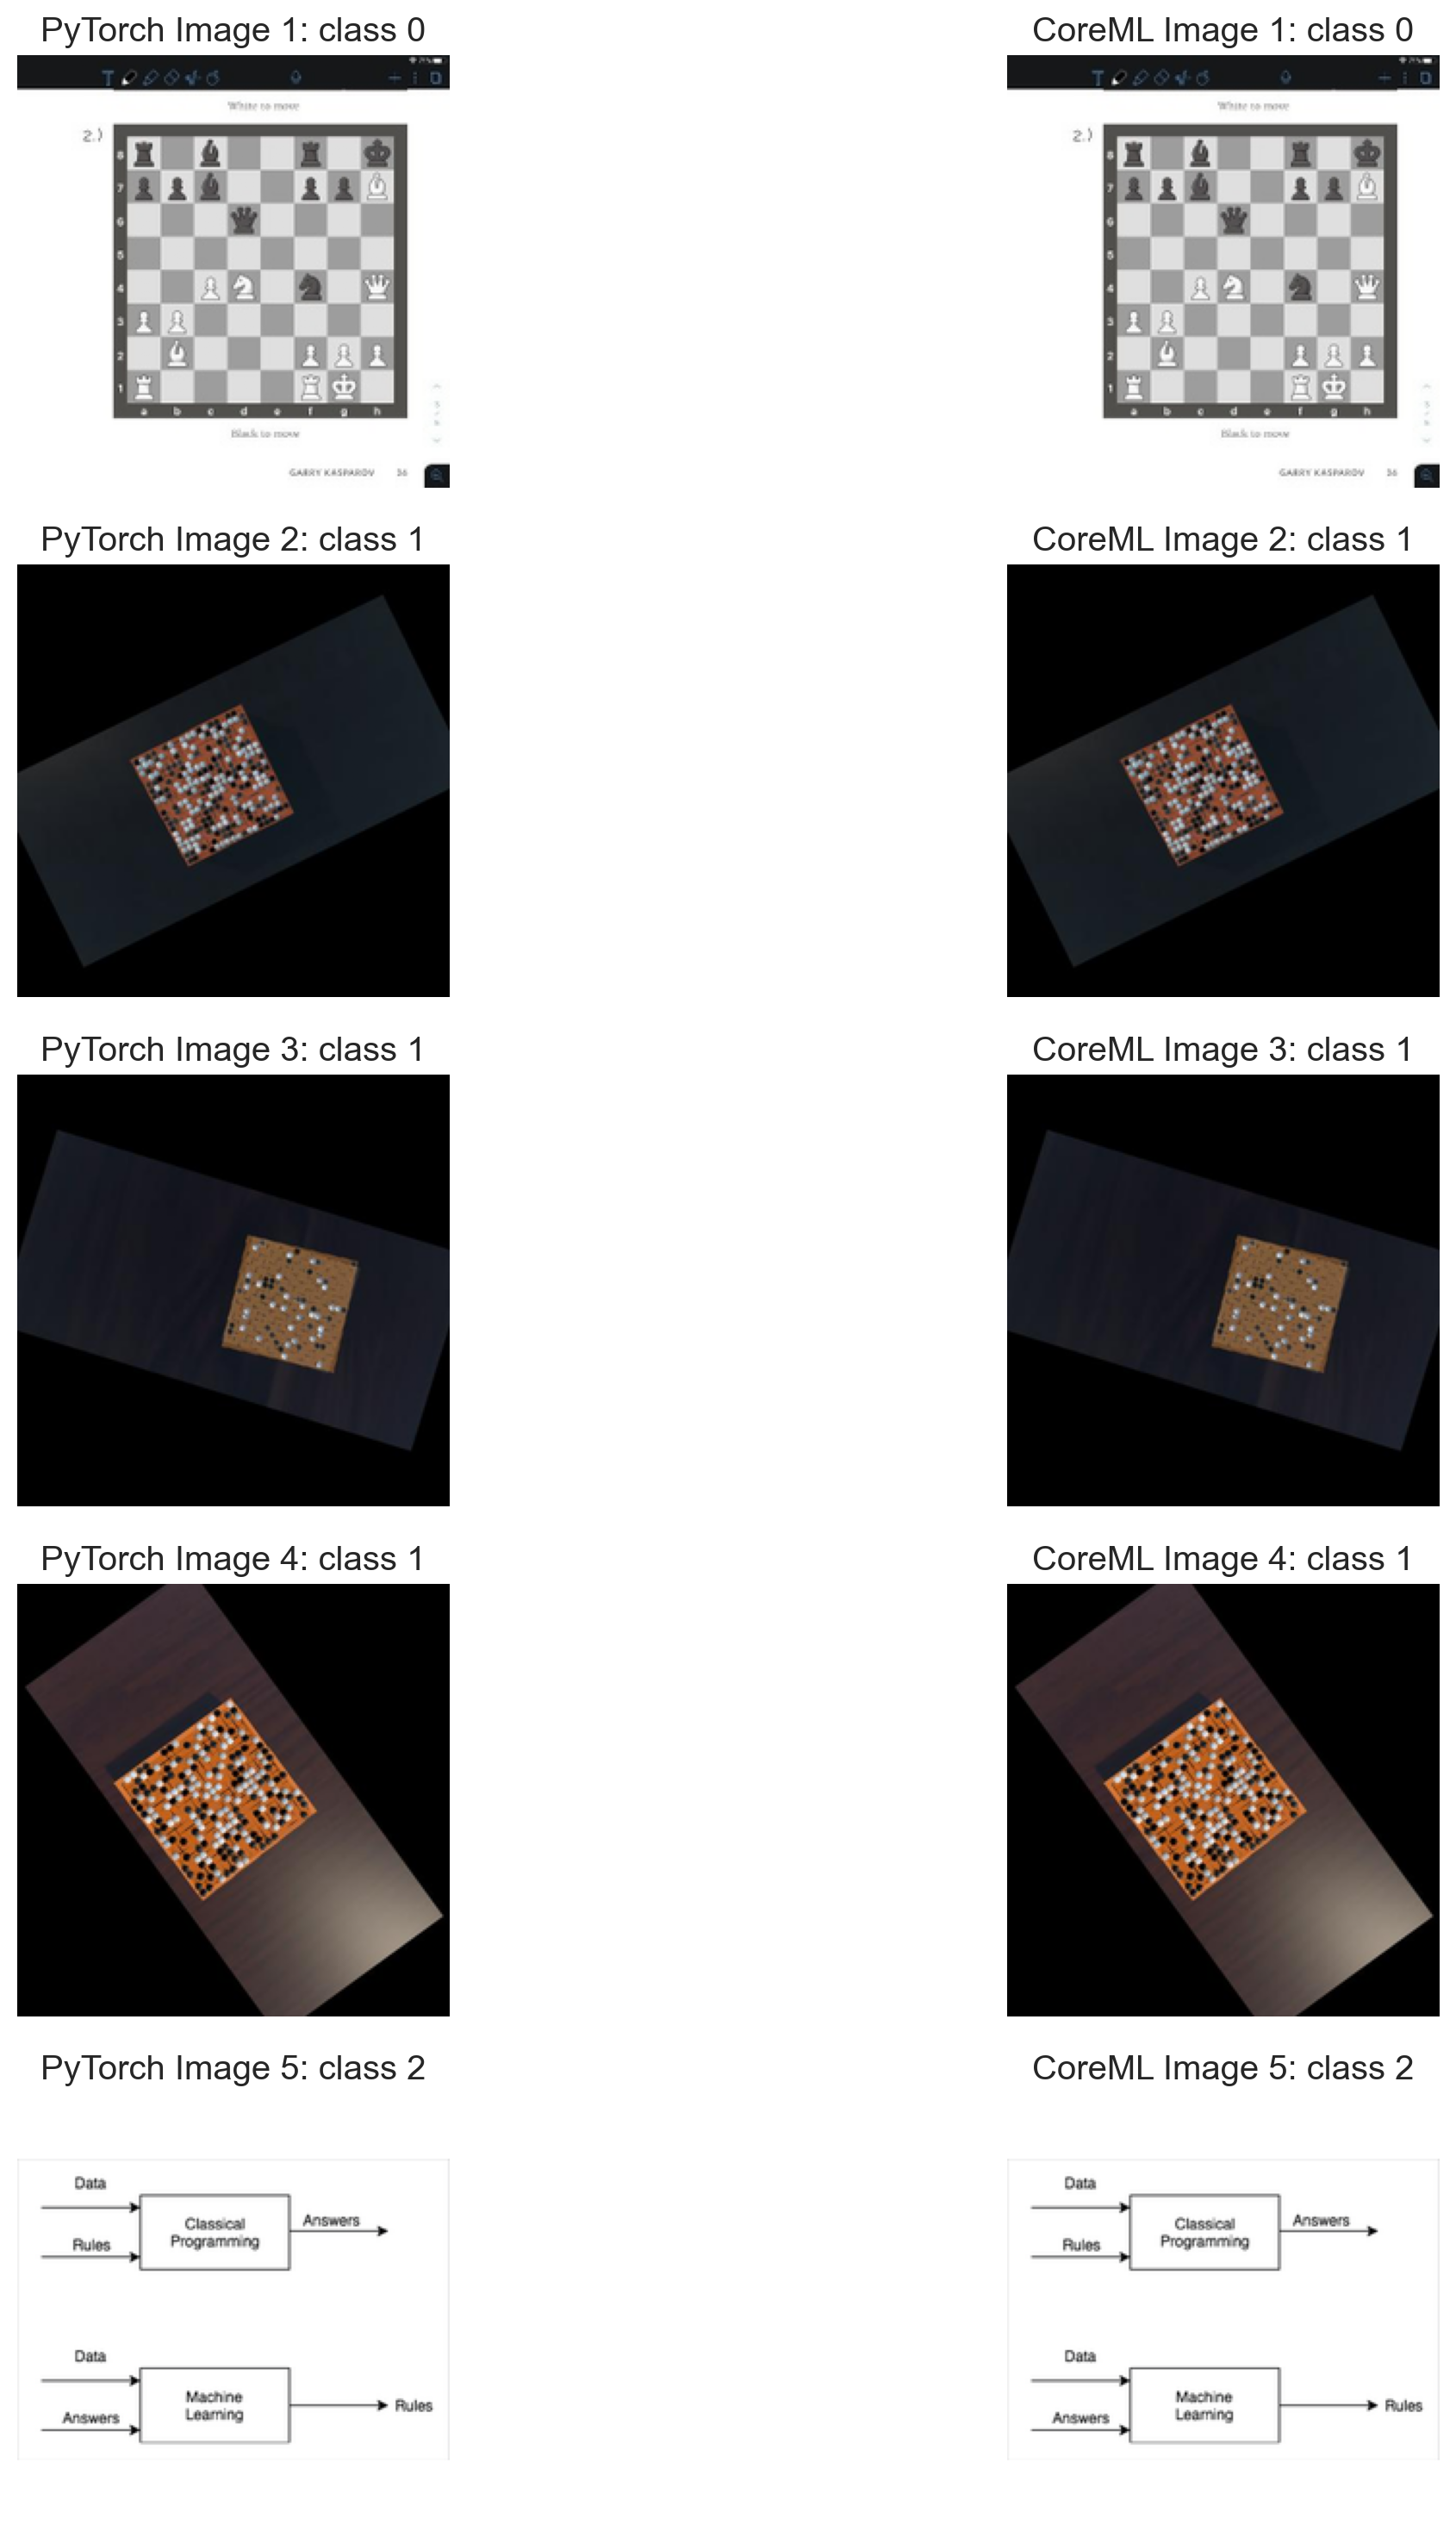

In [22]:
num_images_to_display = 5
fig, axs = plt.subplots(num_images_to_display, 2, figsize=(15, 15))

for i in range(num_images_to_display):
    pytorch_img = pytorch_images[i].permute(1, 2, 0).numpy()
    coreml_img = np.array(coreml_images[i])

    axs[i, 0].imshow(pytorch_img)
    axs[i, 0].set_title(f'PyTorch Image {i+1}: class {true_labels[i]}')
    axs[i, 0].axis('off')

    axs[i, 1].imshow(coreml_img)
    axs[i, 1].set_title(f'CoreML Image {i+1}: class {true_labels[i]}')
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()


In [24]:
import time

@torch.no_grad
def pytorch_evaluate(model, images, device=DEVICE):
    model.to(DEVICE)
    model.eval()
    start_time = time.time()
    predictions = []
    for image in images:
        image = image.unsqueeze(0).to(device)
        output = model(image)
        _, predicted = torch.max(output, 1)
        predictions.append(predicted.item())
    
    end_time = time.time()
    return predictions, end_time - start_time

def coreml_evaluate(coreml_model, images):
    start_time = time.time()
    predictions = []
    for image in images:
        pred = coreml_model.predict({'image': image})
        predictions.append(np.argmax(pred['class'][0]))
    end_time = time.time()
    return predictions, end_time - start_time

cm_str_preds, cm_str_time = coreml_evaluate(coreml_model_str, coreml_images)
cm_opt_preds, cm_opt_time = coreml_evaluate(coreml_model_i8, coreml_images)
pt_preds, pt_time = pytorch_evaluate(squeezenet, pytorch_images)

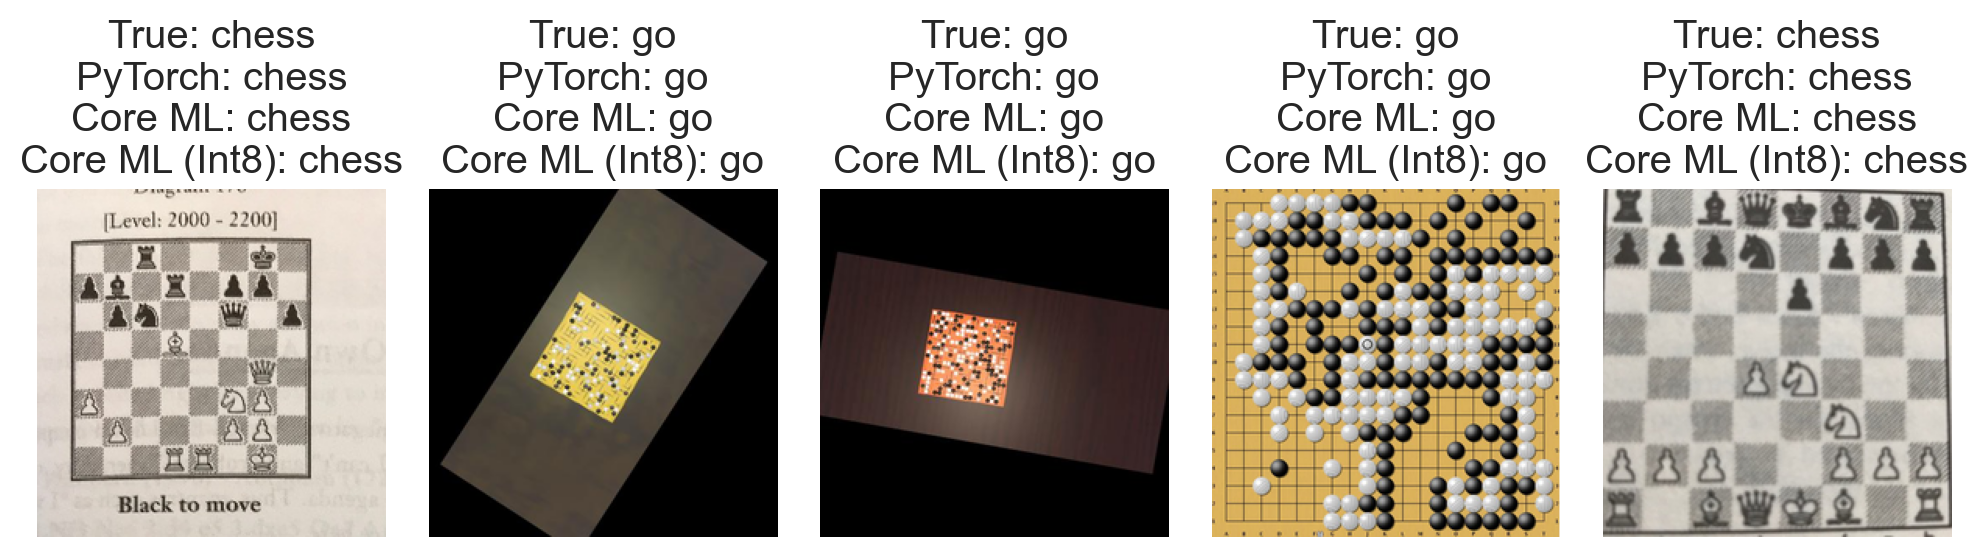

In [25]:
random_indices = random.sample(range(len(true_labels)), 5)
sample_images = [coreml_images[i] for i in random_indices]
sample_labels = [true_labels[i] for i in random_indices]

fig, axs = plt.subplots(1, 5, figsize=(10, 10))
class_names = ['chess', 'go', 'other']
for i, (image, true_label) in enumerate(zip(sample_images, sample_labels)):
    axs[i].imshow(image)
    pred_texts = [
        f"PyTorch: {class_names[pt_preds[random_indices[i]]]}",
        f"Core ML: {class_names[cm_str_preds[random_indices[i]]]}",
        f"Core ML (Int8): {class_names[cm_opt_preds[random_indices[i]]]}"
    ]
    axs[i].set_title(f"True: {class_names[true_label]}\n" + "\n".join(pred_texts))
    axs[i].axis('off')
plt.tight_layout()
plt.show()

In [26]:
def calculate_accuracy_and_correct(predictions, true_labels):
    correct = sum(int(p == t) for p, t in zip(predictions, true_labels))
    accuracy = correct / len(true_labels)
    return accuracy, correct

coreml_str_accuracy, coreml_str_correct = calculate_accuracy_and_correct(cm_str_preds, true_labels)
coreml_opt_accuracy, coreml_opt_correct = calculate_accuracy_and_correct(cm_opt_preds, true_labels)
pytorch_accuracy, pytorch_correct = calculate_accuracy_and_correct(pt_preds, true_labels)

print(f"PyTorch Model - Accuracy: {pytorch_accuracy*100:.2f}%, Correctly Predicted: {pytorch_correct}/{len(true_labels)}")
print(f"Core ML Model - Accuracy: {coreml_str_accuracy*100:.2f}%, Correctly Predicted: {coreml_str_correct}/{len(true_labels)}")
print(f"Core ML INT8 Model - Accuracy: {coreml_opt_accuracy*100:.2f}%, Correctly Predicted: {coreml_opt_correct}/{len(true_labels)}")


PyTorch Model - Accuracy: 100.00%, Correctly Predicted: 200/200
Core ML Model - Accuracy: 100.00%, Correctly Predicted: 200/200
Core ML INT8 Model - Accuracy: 100.00%, Correctly Predicted: 200/200


Построим confusion матрицу и сравним время инференса

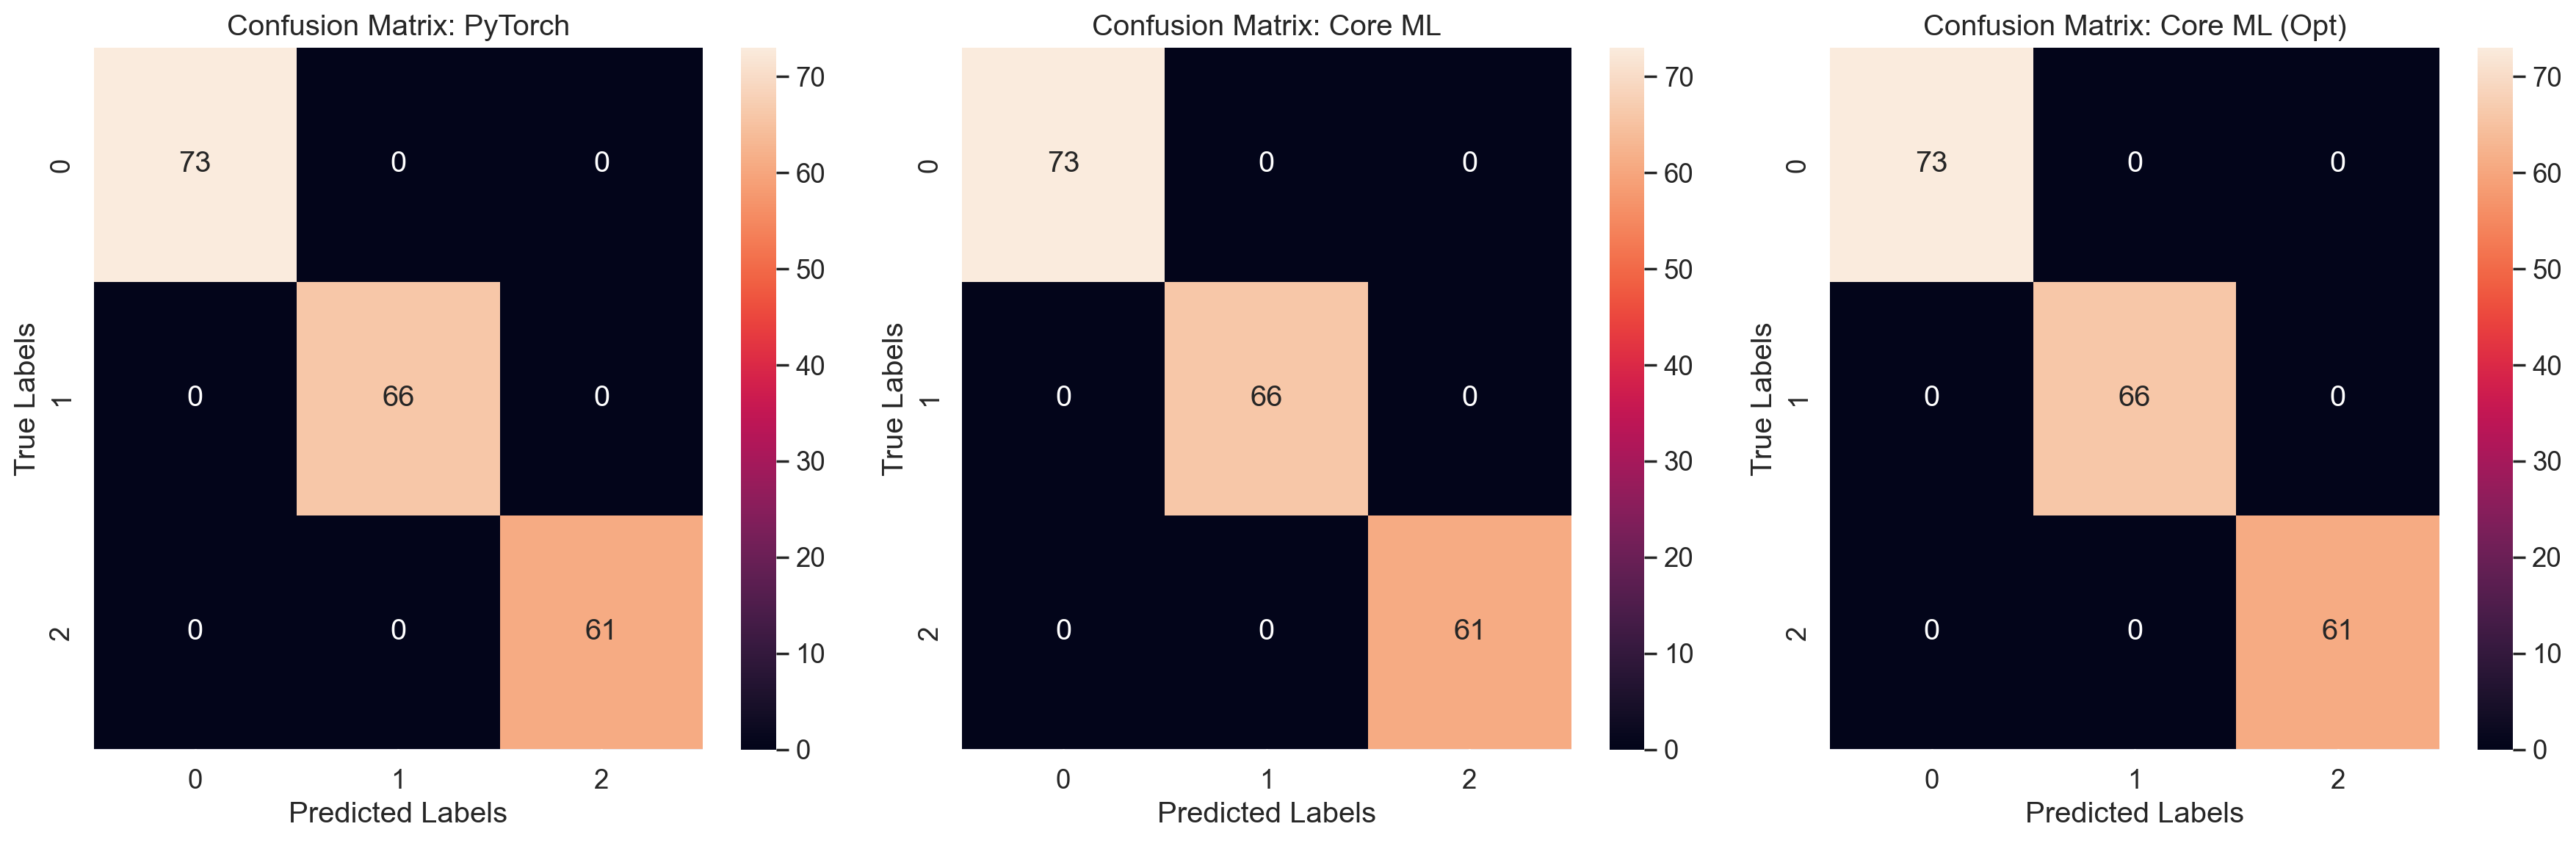

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

fig, ax = plt.subplots(1, 3, figsize=(18, 6))
for i, (preds, title) in enumerate(zip([pt_preds, cm_str_preds, cm_opt_preds], 
                                       ['PyTorch', 'Core ML', 'Core ML (Opt)'])):
    cm = confusion_matrix(true_labels, preds)
    sns.heatmap(cm, annot=True, ax=ax[i], fmt='g')
    ax[i].set_title(f'Confusion Matrix: {title}')
    ax[i].set_xlabel('Predicted Labels')
    ax[i].set_ylabel('True Labels')
plt.tight_layout()
plt.show()

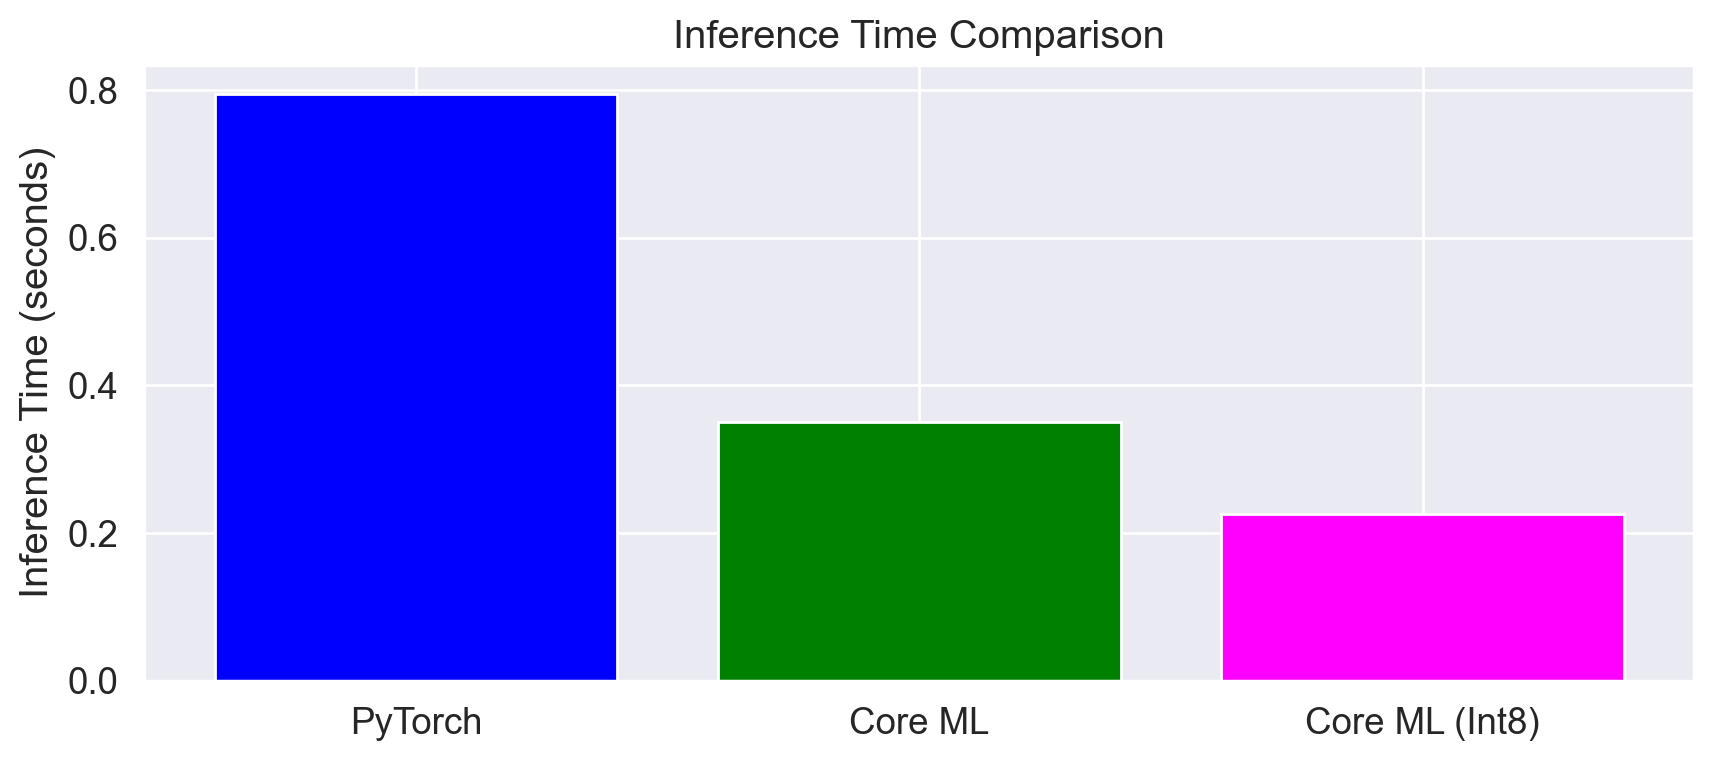

In [28]:
plt.figure(figsize=(10, 4))
plt.bar(['PyTorch', 'Core ML', 'Core ML (Int8)'], [pt_time, cm_str_time, cm_opt_time], color=['blue', 'green', 'magenta'])
plt.ylabel('Inference Time (seconds)')
plt.title('Inference Time Comparison')
plt.show()

## 3. Обучение классификатора на основе MobileNetV3

In [29]:
import torch.nn as nn
import torchvision.models as models

mobilenet_v3_small = models.mobilenet_v3_small(pretrained=True)
mobilenet_v3_small.classifier[3] = nn.Linear(in_features=mobilenet_v3_small.classifier[3].in_features, out_features=num_classes)


/Users/nazaroff/.pyenv/versions/3.11.3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/nazaroff/.pyenv/versions/3.11.3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/30], Step [100/189], Loss: 2.1293
Epoch [1/30], Validation Accuracy: 98.94%
Epoch [2/30], Step [100/189], Loss: 3.6136
Epoch [2/30], Validation Accuracy: 95.49%
Epoch [3/30], Step [100/189], Loss: 0.8226
Epoch [3/30], Validation Accuracy: 99.20%
Epoch [4/30], Step [100/189], Loss: 0.2826
Epoch [4/30], Validation Accuracy: 99.20%
Epoch [5/30], Step [100/189], Loss: 0.4820
Epoch [5/30], Validation Accuracy: 87.00%
Epoch [6/30], Step [100/189], Loss: 0.7069
Epoch [6/30], Validation Accuracy: 97.35%
Epoch [7/30], Step [100/189], Loss: 0.0439
Epoch [7/30], Validation Accuracy: 93.63%
Epoch [8/30], Step [100/189], Loss: 0.9172
Epoch [8/30], Validation Accuracy: 98.41%
Epoch [9/30], Step [100/189], Loss: 0.0277
Epoch [9/30], Validation Accuracy: 99.20%
Epoch [10/30], Step [100/189], Loss: 0.1752
Epoch [10/30], Validation Accuracy: 98.41%
Epoch [11/30], Step [100/189], Loss: 0.7626
Epoch [11/30], Validation Accuracy: 99.20%
Epoch [12/30], Step [100/189], Loss: 0.3282
Epoch [12/30], Va

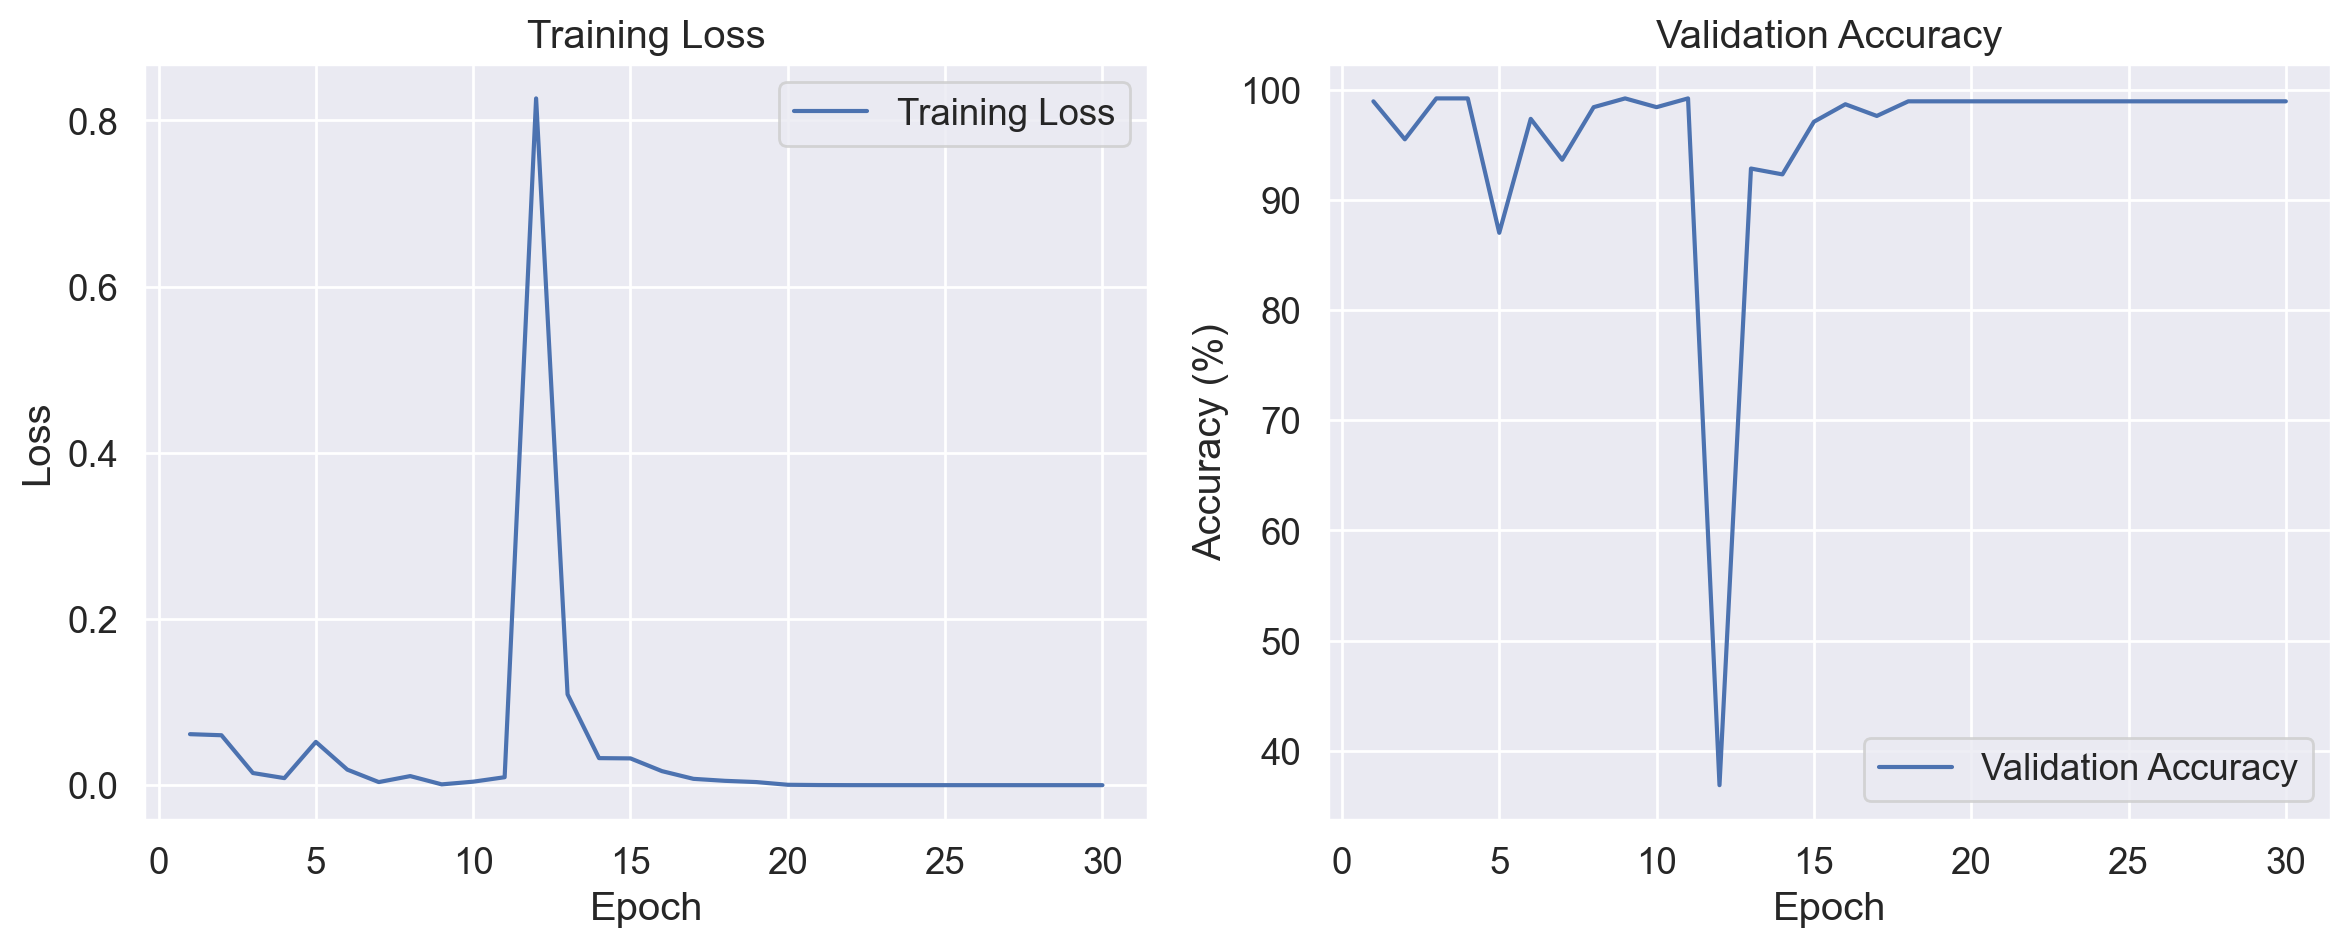

In [280]:
train(mobilenet_v3_small, "mobnetv3", train_loader=train_loader, validation_loader=validation_loader)

График в Tensorboard
<img src="./imgs/tensorboard.png" alt="drawing" width="100%"/>

In [34]:
mobilenet_v3_small = models.mobilenet_v3_small(pretrained=False)
mobilenet_v3_small.classifier[3] = nn.Linear(in_features=mobilenet_v3_small.classifier[3].in_features, out_features=num_classes)
mobilenet_v3_small.load_state_dict(torch.load('mobnetv3_epoch_11.pth', map_location=torch.device('cpu')))
mobilenet_v3_small.eval()

mobilenet_v3_small_traced = torch.jit.trace(mobilenet_v3_small, example_input)

save_model(ct.convert(
    mobilenet_v3_small_traced,
    inputs=[ct.ImageType(name="image", shape=example_input.shape, scale=scale, bias=bias)],
    outputs=[ct.TensorType(name="class")],
    classifier_config=ct.ClassifierConfig(["chess", "go", "other"], predicted_feature_name='labels', predicted_probabilities_output=None),
    minimum_deployment_target=ct.target.iOS15,
    compute_precision=ct.precision.FLOAT16,
    source="pytorch",
    convert_to='mlprogram'
), name="models/chssnet_mn_strings")

save_model(ct.convert(
    mobilenet_v3_small_traced,
    inputs=[ct.ImageType(name="image", shape=example_input.shape, scale=scale, bias=bias)],
    outputs=[ct.TensorType(name="class")],
    minimum_deployment_target=ct.target.iOS15,
    compute_precision=ct.precision.FLOAT16,
    source="pytorch",
    convert_to='mlprogram'
), name="models/chssnet_mn_f16")

/Users/nazaroff/.pyenv/versions/3.11.3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/nazaroff/.pyenv/versions/3.11.3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Running MIL backend_mlprogram pipeline: 100%|██████████| 12/12 [00:00<00:00, 1112.35 passes/s]


In [36]:
chssnet_mn_f16_mlmodel = ct.models.MLModel('models/chssnet_mn_f16.mlpackage')
op_config = cto.OpLinearQuantizerConfig(mode="linear_symmetric")
chssnet_mn_f16_mlmodel_comp = cto.linear_quantize_weights(chssnet_mn_f16_mlmodel, cto.OptimizationConfig(global_config=op_config))
chssnet_mn_f16_mlmodel_comp.save('models/chssnet_mn_i8.mlpackage')

Running compression pass linear_quantize_weights:   0%|          | 0/106 [00:00<?, ? ops/s]/Users/nazaroff/.pyenv/versions/3.11.3/lib/python3.11/site-packages/coremltools/optimize/coreml/_quantization_passes.py:686: RuntimeWarning: divide by zero encountered in divide
  quantized_data = np.round(original_data / scale)
/Users/nazaroff/.pyenv/versions/3.11.3/lib/python3.11/site-packages/coremltools/optimize/coreml/_quantization_passes.py:686: RuntimeWarning: invalid value encountered in divide
  quantized_data = np.round(original_data / scale)
/Users/nazaroff/.pyenv/versions/3.11.3/lib/python3.11/site-packages/coremltools/optimize/coreml/_quantization_passes.py:690: RuntimeWarning: invalid value encountered in cast
  quantized_data = np.clip(quantized_data, q_val_min, q_val_max).astype(np_dtype)
Running compression pass linear_quantize_weights: 100%|██████████| 106/106 [00:00<00:00, 2064.66 ops/s]
Running MIL frontend_milinternal pipeline: 0 passes [00:00, ? passes/s]
Running MIL backend